In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering,DBSCAN
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
X_sc = pd.read_csv('./X_scaled.csv')

In [3]:
all_features = X_sc.columns

In [4]:
## FUNCION MODEL PARAMETERS
model_dic = {"kmeans": {"init_seed": [10],
                  "inits"  :  ["k-means++","random"],
                  "clusters_list": range(2,20),
                  "tol": 0.0001},
            "hierarchy": {"linkage_method":['complete','ward', 'single',
                           'centroid','median','weighted'],"t": range(4,15),
                          "criterion": "maxclust"},
           "Agglomerative": {"linkage_method":['complete','ward', 'single',
                             'centroid','median','weighted'],
                             'clusters_list':range(4,15),
                             "affinity": ['euclidean', 'l1', 'l2', 'manhattan',
                                      'cosine', 'precomputed'],
                         "clusters_list": range(4,10)},
            "dbscan": {"epslons":np.linspace(0.5,20,20),
                       "min_samples": [1,3,5,7,9,11,13,15,17,19,21,23,25,27,31]            
            }}
## FUNCION DATA FRAME PARAMETERS
df_dic = {'all_features': X_sc[all_features]}

In [5]:
def grid_clusters(df_dic, par_dic):
    result_dic = {"Data_frame" :[],
                  "model": [],
                  "inertia": [],
                  "silhouette": [],
                  "Numb_clusters": [],
                  "Cluster_counts": [],
                  "model_params": []
                  }
    # loop dataFrames
    for df_name, df_data in df_dic.items():
        X = df_data
        # loop models
        for n_model in par_dic.keys():
            if n_model == "kmeans":
                # loop centroid seeds
                for n_init_seed in par_dic['kmeans']['init_seed']:
                    # loop Method for initialization
                    for n_init_method in par_dic['kmeans']['inits']:
                            # loop number of clusters
                            for n_cluster in par_dic['kmeans']['clusters_list']:
                                kmeans = KMeans(n_clusters=n_cluster,
                                                init=n_init_method,
                                                n_init=n_init_seed,
                                                tol=par_dic['kmeans']['tol'],
                                                random_state=42)
                                kmeans.fit(X)
                                #Saving results in dic
                                result_dic['Data_frame'].append(df_name)
                                result_dic['model'].append(n_model)
                                result_dic['inertia'].append(kmeans.inertia_)
                                result_dic['silhouette'].append(silhouette_score(X, kmeans.labels_))
                                result_dic['Numb_clusters'].append(n_cluster)
                                result_dic['Cluster_counts'].append(list(pd.Series(kmeans.labels_).value_counts()))
                                result_dic['model_params'].append(par_dic['kmeans']) 
                                
            if n_model == "hierarchy":
                # loop linkage_method
                for n_link_met in par_dic['hierarchy']['linkage_method']:
                    for n_clusters in par_dic['hierarchy']['t']:
                        z = hierarchy.linkage(X, method=n_link_met)
                        cls = hierarchy.fcluster(z, n_clusters, "maxclust")
                        # Saving results in dic
                        result_dic['Data_frame'].append(df_name)
                        result_dic['model'].append(n_model)
                        result_dic['inertia'].append(0)
                        result_dic['silhouette'].append(silhouette_score(X, cls))
                        result_dic['Numb_clusters'].append(n_clusters)
                        result_dic['Cluster_counts'].append(list(pd.Series(cls).value_counts()))
                        result_dic['model_params'].append(n_link_met)
                        
            if n_model == "Agglomerative":
                # loop linkage criterion
                for n_link_met in par_dic['Agglomerative']['linkage_method']:
                    #loop number of clusters
                    for n_clusters in par_dic['Agglomerative']['clusters_list']:
                        # loop method to compute linkage
                        for n_affinity in par_dic['Agglomerative']['affinity']:
                            ac = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
                            ac.fit(X)
                            # Saving results in dic
                            result_dic['Data_frame'].append(df_name)
                            result_dic['model'].append(n_model)
                            result_dic['inertia'].append(0)
                            result_dic['silhouette'].append(silhouette_score(X, ac.labels_))
                            result_dic['Numb_clusters'].append(n_clusters)
                            result_dic['Cluster_counts'].append(list(pd.Series(ac.labels_).value_counts()))
                            result_dic['model_params'].append("Afin:" + n_affinity + ", Link M, " + n_link_met)
            
            if n_model == "dbscan":
                for e in par_dic['dbscan']['epslons']:
                    for samp in par_dic['dbscan']['min_samples']:
                        dbsc = DBSCAN(eps = e,
                                      min_samples = samp,
                                      metric='euclidean',
                                      leaf_size=30
                                      ).fit(X)
                        n_clusters = len(list(pd.Series(dbsc.labels_).value_counts()))
                        if n_clusters > 1 :      
                            result_dic['Data_frame'].append(df_name)
                            result_dic['model'].append(n_model)
                            result_dic['inertia'].append(0)
                            result_dic['silhouette'].append(silhouette_score(X, dbsc.labels_))
                            result_dic['Numb_clusters'].append(n_clusters)
                            result_dic['Cluster_counts'].append(list(pd.Series(dbsc.labels_).value_counts()))
                            result_dic['model_params'].append("Epslon:" + str(round(e,2)) + ", min_samp: " + str(samp))                           
    return pd.DataFrame(result_dic)

In [6]:
results = grid_clusters(df_dic,model_dic)

In [20]:
# Top agglomerative silhouette score
display(results[(results.model == 'Agglomerative')]\
.sort_values(by=['silhouette'],ascending = False).head(4))

# Top kmeans silhouette score
display(results[(results.model == 'kmeans')]\
.sort_values(by=['silhouette'],ascending = False).head(4))

# Top hierarchy silhouette score
display(results[(results.model == 'hierarchy')]\
.sort_values(by=['silhouette'],ascending = False).head(4))

# Top dbscan silhouette score
display(results[(results.model == 'dbscan') &
               (results.Numb_clusters >= 1)]\
.sort_values(by=['silhouette'],ascending = False).head(4))


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
317,all_features,Agglomerative,0.0,0.174013,9,"[509, 424, 185, 137, 62, 36, 22, 3, 2]","Afin:precomputed, Link M, weighted"
209,all_features,Agglomerative,0.0,0.174013,9,"[509, 424, 185, 137, 62, 36, 22, 3, 2]","Afin:precomputed, Link M, single"
168,all_features,Agglomerative,0.0,0.174013,9,"[509, 424, 185, 137, 62, 36, 22, 3, 2]","Afin:euclidean, Link M, ward"
132,all_features,Agglomerative,0.0,0.174013,9,"[509, 424, 185, 137, 62, 36, 22, 3, 2]","Afin:euclidean, Link M, complete"


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
0,all_features,kmeans,60426.624593,0.301489,2,"[1042, 338]","{'init_seed': [10], 'inits': ['k-means++', 'ra..."
18,all_features,kmeans,60426.624593,0.301489,2,"[1042, 338]","{'init_seed': [10], 'inits': ['k-means++', 'ra..."
16,all_features,kmeans,28330.111727,0.211178,18,"[248, 242, 185, 169, 155, 96, 59, 43, 42, 36, ...","{'init_seed': [10], 'inits': ['k-means++', 'ra..."
15,all_features,kmeans,29336.526257,0.206166,17,"[383, 265, 198, 173, 96, 51, 44, 44, 40, 35, 2...","{'init_seed': [10], 'inits': ['k-means++', 'ra..."


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
69,all_features,hierarchy,0.0,0.688751,4,"[1376, 2, 1, 1]",centroid
91,all_features,hierarchy,0.0,0.688751,4,"[1376, 2, 1, 1]",weighted
80,all_features,hierarchy,0.0,0.688751,4,"[1376, 2, 1, 1]",median
70,all_features,hierarchy,0.0,0.686717,5,"[1373, 3, 2, 1, 1]",centroid


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
608,all_features,dbscan,0.0,0.732035,2,"[1372, 8]","Epslon:20.0, min_samp: 31"
593,all_features,dbscan,0.0,0.732035,2,"[1372, 8]","Epslon:18.97, min_samp: 31"
581,all_features,dbscan,0.0,0.732035,2,"[1372, 8]","Epslon:18.97, min_samp: 5"
582,all_features,dbscan,0.0,0.732035,2,"[1372, 8]","Epslon:18.97, min_samp: 7"


## Chosing good models based on:
1. Silhuete score 
2. Inertia( for kmeans)
3. cluster count distributuion

## DBSCAN

In [21]:
display(results[(results.model == 'dbscan') &
               (results.Numb_clusters >= 3 )]\
.sort_values(by=['silhouette'],ascending = False)[48:60])

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
404,all_features,dbscan,0.0,0.301644,4,"[1263, 73, 26, 18]","Epslon:6.66, min_samp: 11"
405,all_features,dbscan,0.0,0.301498,4,"[1261, 75, 26, 18]","Epslon:6.66, min_samp: 13"
406,all_features,dbscan,0.0,0.301498,4,"[1261, 75, 26, 18]","Epslon:6.66, min_samp: 15"
407,all_features,dbscan,0.0,0.301498,4,"[1261, 75, 26, 18]","Epslon:6.66, min_samp: 17"
414,all_features,dbscan,0.0,0.236785,24,"[1323, 22, 8, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1,...","Epslon:7.68, min_samp: 1"
401,all_features,dbscan,0.0,0.179947,6,"[1278, 45, 26, 18, 8, 5]","Epslon:6.66, min_samp: 5"
402,all_features,dbscan,0.0,0.177850,5,"[1276, 52, 26, 18, 8]","Epslon:6.66, min_samp: 7"
400,all_features,dbscan,0.0,0.170175,11,"[1279, 29, 26, 18, 8, 5, 3, 3, 3, 3, 3]","Epslon:6.66, min_samp: 3"
399,all_features,dbscan,0.0,0.155651,37,"[1279, 26, 18, 8, 5, 3, 3, 3, 3, 3, 2, 2, 1, 1...","Epslon:6.66, min_samp: 1"
370,all_features,dbscan,0.0,0.140745,18,"[1010, 98, 97, 44, 21, 19, 19, 17, 14, 7, 7, 6...","Epslon:4.61, min_samp: 3"


In [22]:
## DBSCAN Parameters Chosen:
display(results.loc[[378,376]])
# saving labels 
dbsc_1 = DBSCAN(eps = 6.66, min_samples = 19).fit(X_sc).labels_
# dbsc_2 = DBSCAN(eps = 3.58, min_samples = 5).fit(X_sc).labels_

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
378,all_features,dbscan,0.0,0.117035,5,"[973, 263, 85, 38, 21]","Epslon:4.61, min_samp: 19"
376,all_features,dbscan,0.0,0.118803,5,"[974, 259, 88, 38, 21]","Epslon:4.61, min_samp: 15"


## Hierarchy

In [23]:
display(results[(results.model == 'hierarchy') &
               (results.Numb_clusters >= 3 )]\
.sort_values(by=['silhouette'],ascending = False)[20:50])

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
74,all_features,hierarchy,0.0,0.552074,9,"[1369, 3, 2, 1, 1, 1, 1, 1, 1]",centroid
85,all_features,hierarchy,0.0,0.552074,9,"[1369, 3, 2, 1, 1, 1, 1, 1, 1]",median
86,all_features,hierarchy,0.0,0.550880,10,"[1366, 3, 3, 2, 1, 1, 1, 1, 1, 1]",median
95,all_features,hierarchy,0.0,0.531764,8,"[1360, 9, 4, 2, 2, 1, 1, 1]",weighted
75,all_features,hierarchy,0.0,0.523949,10,"[1366, 3, 3, 2, 1, 1, 1, 1, 1, 1]",centroid
96,all_features,hierarchy,0.0,0.518419,9,"[1360, 6, 4, 3, 2, 2, 1, 1, 1]",weighted
97,all_features,hierarchy,0.0,0.517822,10,"[1360, 6, 4, 3, 2, 1, 1, 1, 1, 1]",weighted
88,all_features,hierarchy,0.0,0.516564,12,"[1360, 6, 3, 3, 2, 1, 1, 1, 1, 1, 1]",median
87,all_features,hierarchy,0.0,0.516564,11,"[1360, 6, 3, 3, 2, 1, 1, 1, 1, 1, 1]",median
98,all_features,hierarchy,0.0,0.516564,11,"[1360, 6, 3, 3, 2, 1, 1, 1, 1, 1, 1]",weighted


In [24]:
## Hierarchy Parameters:
display(results.loc[[47]])
# saving labels 
z = hierarchy.linkage(X_sc, method="ward")
hierarchy_1 = hierarchy.fcluster(z, 9, "maxclust")

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
47,all_features,hierarchy,0.0,0.142208,4,"[607, 424, 347, 2]",ward


## Agglomerative

In [25]:
display(results[(results.model == 'Agglomerative')]\
.sort_values(by=['silhouette'],ascending = False).head(1))

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
317,all_features,Agglomerative,0.0,0.174013,9,"[509, 424, 185, 137, 62, 36, 22, 3, 2]","Afin:precomputed, Link M, weighted"


In [26]:
# Agglomerative parameters
ac = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
ac.fit(X_sc)
agglomerative_1 = ac.labels_

## Kmeans

In [27]:
display(results[(results.model == 'kmeans')]\
.sort_values(by=['silhouette'],ascending = False).\
        sort_values(by=['inertia'],ascending = True).head(4))

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
17,all_features,kmeans,27940.601813,0.197466,19,"[263, 248, 198, 155, 96, 89, 85, 44, 40, 35, 3...","{'init_seed': [10], 'inits': ['k-means++', 'ra..."
16,all_features,kmeans,28330.111727,0.211178,18,"[248, 242, 185, 169, 155, 96, 59, 43, 42, 36, ...","{'init_seed': [10], 'inits': ['k-means++', 'ra..."
15,all_features,kmeans,29336.526257,0.206166,17,"[383, 265, 198, 173, 96, 51, 44, 44, 40, 35, 2...","{'init_seed': [10], 'inits': ['k-means++', 'ra..."
35,all_features,kmeans,30791.802334,0.146092,19,"[254, 192, 152, 114, 92, 88, 85, 63, 52, 51, 4...","{'init_seed': [10], 'inits': ['k-means++', 'ra..."


In [28]:
# Kmeans parameters
results.loc[17]['model_params']

{'init_seed': [10],
 'inits': ['k-means++', 'random'],
 'clusters_list': range(2, 20),
 'tol': 0.0001}

In [29]:
kmeans_1 = KMeans(n_clusters=19, init='random',
                random_state=42).fit(X_sc).labels_


In [34]:
# raw_df.groupby(['dbscan_s9_e_4.5'])[["Return_6m",'Return_12m','Return_24m']].agg([np.median])

In [ ]:
## Checking number of Cluster using the elbow method

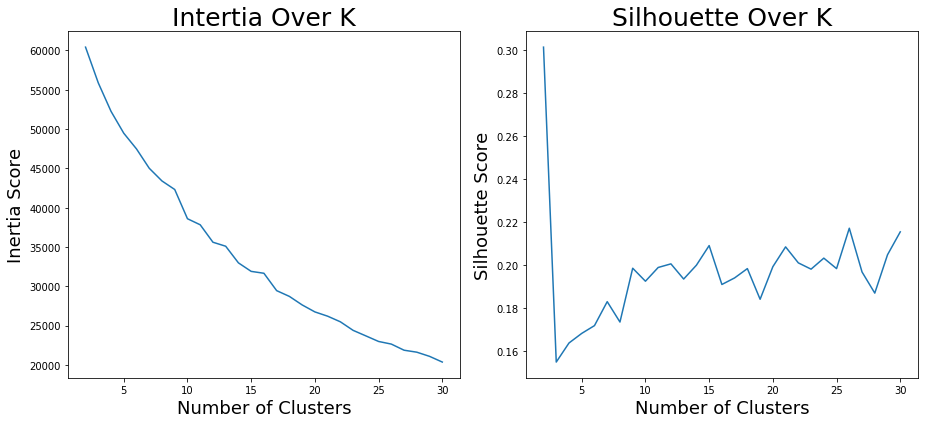

In [35]:
from sklearn.metrics import silhouette_score 
from sklearn.model_selection import ParameterGrid

class eval_kmeans:
    
    param_grid = dict(n_clusters=np.arange(2, 31))
    model = None
    scores = []
    
    def __init__(self, param_grid = None):
        
        if param_grid:
            self.param_grid = ParameterGrid(param_grid)
    
    def fit(self, X, scorer="silhouette"):
        
        ## This isn't very smart ATM.  Only one param, K, is being searched.
        for param, values in self.param_grid.items():
            
            for value in values:
        
                estimator = KMeans(n_clusters = value,)
                model = estimator.fit(X)
                
                # Populate scores
                score    = silhouette_score(X, model.labels_)
                
                self.scores.append({
                    param:        value,
                    "inertia":    model.inertia_,
                    "silhouette": score
                })
                
    def get_scores(self):
        return pd.DataFrame(self.scores)
    
kmeans = eval_kmeans()
kmeans.fit(X_sc[all_features])

eval_scores = kmeans.get_scores()
eval_scores.set_index("n_clusters", inplace=True)

fig, ax = plt.subplots(ncols=2, figsize=(13, 6))
eval_scores["inertia"].plot(ax=ax[0], title="Intertia Over K")
eval_scores["silhouette"].plot(ax=ax[1], title="Silhouette Over K")

# Add the arrow!
# ax[0].arrow(3, 370, 5, 105, head_width=3, head_length=10, fc='k', ec='k')
# ax[0].annotate('Elbow @ K=4', xy = (0.10, .46),  xycoords = 'axes fraction', \
#     xytext = (0.24, 0.45), fontsize = 14, \
#     color = '#303030', arrowprops=dict(facecolor='black', shrink=0.05))
# ax[1].annotate('Elbow @ K=4', xy = (0.13, .56),  xycoords = 'axes fraction', \
#     xytext = (0.24, 0.65), fontsize = 14, \
#     color = '#303030', arrowprops=dict(facecolor='black', shrink=0.05))
ax[0].set_title('Intertia Over K',fontsize = 25)
ax[1].set_title('Silhouette Over K',fontsize = 25)
ax[0].set_xlabel('Number of Clusters', size = 18)
ax[1].set_xlabel('Number of Clusters', size = 18)
ax[0].set_ylabel('Inertia Score', size = 18)
ax[1].set_ylabel('Silhouette Score', size = 18)

fig.tight_layout()

## Adding clusters classifications to DF



In [89]:
raw_df = pd.read_csv('./clean_df.csv')

raw_df['dbsc_1'] = dbsc_1
raw_df['agglomerative_1'] = agglomerative_1
raw_df['hierarchy_1'] = hierarchy_1
raw_df['kmeans_1'] = kmeans_1

In [90]:
X_train = raw_df.drop(['Name','CNPJ','agglomerative_1'
                       ,'dbsc_1','hierarchy_1','kmeans_1'
                      ,'Portfolio Manager','Last_Assets_date'], 
                      axis=1)

y_train_dbscan = raw_df['dbsc_1']
y_train_agglom = raw_df['agglomerative_1']
y_train_hierar = raw_df['hierarchy_1']
y_train_kmeans = raw_df['kmeans_1']

In [123]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

my_params = {'criterion': ['gini', 'entropy'],
                    'n_estimators' : [3,4,5,10,20],
#                    'max_depth': ['10, 15, 20']
                    'max_features' : ['auto' , 1.0,0.5,0.75]
                    }

gs = GridSearchCV(RandomForestClassifier(random_state=42),my_params,cv=5)
gs.fit(X_train,y_train_kmeans)

print(gs.best_score_)
print(gs.best_params_)
# print(gs.score(X_val,y_val))
# predictions = gs.predict(test[features])




C:\Users\berku\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\berku\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.9347826086956522
{'criterion': 'entropy', 'max_features': 0.75, 'n_estimators': 20}


## DBSCAN best param random forest:
- 0.9797101449275363
- {'criterion': 'gini', 'max_features': 1.0, 'n_estimators': 20}

In [114]:
rf = RandomForestClassifier(random_state=42,criterion='gini',max_features=1.0 ,n_estimators = 20)
rf.fit(X_train,y_train_dbscan)

importances = rf.feature_importances_
type(importances)
coef_df = pd.DataFrame()

coef_df['coef_name'] = X_train.columns.values
coef_df['dbscan_coef_val'] = importances

In [115]:
coef_df.sort_values(['dbscan_coef_val'],ascending=False).head(10)

,coef_name,dbscan_coef_val
27,Benchmark_IBX,0.233470
18,CVM Category_FX,0.187581
1,Minimum Investment,0.067685
26,Benchmark_Dollar,0.065657
5,Tax Classification_Exempt,0.062103
31,Last_Assets,0.026742
32,Assets_Flow_6m,0.024071
51,Excess_Return_-_Dollar_12m,0.023613
22,Performance Fee Reference Index_100% do IBX,0.022499
52,Excess_Return_-_Dollar_24m,0.021597


## Agglomerative best param:
- 0.9746376811594203
- {'criterion': 'gini', 'max_features': 0.5, 'n_estimators': 20}

In [116]:
rf = RandomForestClassifier(random_state=42,criterion='gini',max_features=0.5 ,n_estimators = 20)
rf.fit(X_train,y_train_agglom)

importances = rf.feature_importances_

coef_df['agglomerative_coef_val'] = importances

In [118]:
coef_df.sort_values(['agglomerative_coef_val'],ascending=False).head(10)

,coef_name,dbscan_coef_val,agglomerative_coef_val
19,CVM Category_Fixed Income,0.000000,0.299480
21,CVM Category_Multimarket,0.000334,0.191354
43,Volatility_24m,0.007262,0.101678
41,Volatility_6m,0.004110,0.089846
6,Tax Classification_Long Term,0.000000,0.043259
42,Volatility_12m,0.002600,0.041821
10,Private Credit Anbima_Yes,0.001098,0.030311
24,Performance Fee Reference Index_Other_performa...,0.020789,0.026327
3,Liquidity Ratios,0.021439,0.025350
2,Performance Fee,0.000552,0.018486


## Hierarchy 
- 0.9565217391304348
- {'criterion': 'gini', 'max_features': 1.0, 'n_estimators': 10}

In [120]:
rf = RandomForestClassifier(random_state=42,criterion='gini',max_features=1 ,n_estimators = 10)
rf.fit(X_train,y_train_hierar)

importances = rf.feature_importances_
coef_df['hierarchy_coef_val'] = importances

In [122]:
coef_df.sort_values(['hierarchy_coef_val'],ascending=False).head(10)

,coef_name,dbscan_coef_val,agglomerative_coef_val,hierarchy_coef_val
41,Volatility_6m,0.004110,0.089846,0.062097
19,CVM Category_Fixed Income,0.000000,0.299480,0.044858
23,Performance Fee Reference Index_100% do Ibovespa,0.000000,0.000000,0.042166
52,Excess_Return_-_Dollar_24m,0.021597,0.005190,0.041688
21,CVM Category_Multimarket,0.000334,0.191354,0.040116
50,Excess_Return_-_Dollar_6m,0.004351,0.001861,0.039527
2,Performance Fee,0.000552,0.018486,0.035707
25,Performance Fee Reference Index_There is not,0.000000,0.013229,0.035629
6,Tax Classification_Long Term,0.000000,0.043259,0.035179
42,Volatility_12m,0.002600,0.041821,0.033984


## K means
- 0.9347826086956522
- {'criterion': 'entropy', 'max_features': 0.75, 'n_estimators': 20}

In [124]:
rf = RandomForestClassifier(random_state=42,criterion='entropy',max_features=0.75 ,n_estimators = 20)
rf.fit(X_train,y_train_kmeans)

importances = rf.feature_importances_
coef_df['kmeans_coef_val'] = importances

In [125]:
coef_df.sort_values(['kmeans_coef_val'],ascending=False).head(10)

,coef_name,dbscan_coef_val,agglomerative_coef_val,hierarchy_coef_val,kmeans_coef_val
19,CVM Category_Fixed Income,0.000000,0.299480,0.044858,0.200900
21,CVM Category_Multimarket,0.000334,0.191354,0.040116,0.098284
10,Private Credit Anbima_Yes,0.001098,0.030311,0.004999,0.072556
25,Performance Fee Reference Index_There is not,0.000000,0.013229,0.035629,0.066469
29,Benchmark_Not Informed,0.000000,0.000000,0.006365,0.047169
2,Performance Fee,0.000552,0.018486,0.035707,0.039637
23,Performance Fee Reference Index_100% do Ibovespa,0.000000,0.000000,0.042166,0.037319
41,Volatility_6m,0.004110,0.089846,0.062097,0.036041
30,Benchmark_Other_Benchmark,0.000238,0.000696,0.003753,0.034365
50,Excess_Return_-_Dollar_6m,0.004351,0.001861,0.039527,0.030719


In [ ]:
tsne

In [131]:
# 'dbsc_1', 'agglomerative_1','hierarchy_1',
raw_df.groupby([ 'kmeans_1'])\
                [["CVM Category_Fixed Income",'CVM Category_Multimarket'
                 ,'Private Credit Anbima_Yes','Performance Fee Reference Index_There is not',
                'Benchmark_Not Informed','Performance Fee','Volatility_6m','Excess_Return_-_Dollar_6m'
                 ]].agg([np.median])

,CVM Category_Fixed Income,CVM Category_Multimarket,Private Credit Anbima_Yes,Performance Fee Reference Index_There is not,Benchmark_Not Informed,Performance Fee,Volatility_6m,Excess_Return_-_Dollar_6m
,median,median,median,median,median,median,median,median
kmeans_1,,,,,,,,
0,0,0,0,1,1,0.0,0.181186,0.150831
1,1,0,0,1,0,0.0,0.000203,0.056754
2,0,0,0,0,0,0.2,0.217486,0.252970
3,0,1,0,1,0,0.0,0.040577,0.062482
4,0,0,0,0,0,0.2,0.207468,0.269661
5,1,0,0,1,1,0.0,0.000917,0.055146
6,0,0,0,1,0,0.0,0.222981,0.246461
7,1,0,0,1,0,0.0,0.000158,0.056846


In [133]:
raw_df.columns

Index(['Name', 'CNPJ', 'Management Fee', 'Minimum Investment',
       'Performance Fee', 'Portfolio Manager', 'Liquidity Ratios',
       'age_months', 'Tax Classification_Exempt',
       'Tax Classification_Long Term', 'Tax Classification_Short Term',
       'Private Credit Anbima_Non-classified',
       'Private Credit Anbima_Not applicable', 'Private Credit Anbima_Yes',
       'Leveraged Anbima_Non-classified', 'Leveraged Anbima_Yes',
       'Legal Classification_FI', 'Legal Classification_FIC',
       'Entidade de Previdência 3922_US_Yes',
       'Entidade de Previdência 4444_US_Yes',
       'Entidade de Previdência 4661_US_Yes', 'CVM Category_FX',
       'CVM Category_Fixed Income', 'CVM Category_Index Market',
       'CVM Category_Multimarket',
       'Performance Fee Reference Index_100% do IBX',
       'Performance Fee Reference Index_100% do Ibovespa',
       'Performance Fee Reference Index_Other_performance_fee',
       'Performance Fee Reference Index_There is not', 'Benchma

In [153]:
for i in np.linspace(0,1,10):
    print(round(i,2), raw_df['Liquidity Ratios'].quantile(i)) 

0.0 0.0
0.11 0.0
0.22 0.0
0.33 1.0
0.44 1.0
0.56 4.0
0.67 4.0
0.78 8.0
0.89 22.0
1.0 504.0


In [139]:
raw_df.groupby(['agglomerative_1'])\
                [["CVM Category_Fixed Income",'CVM Category_Multimarket'
                  ,'Volatility_24m','Volatility_6m','Tax Classification_Long Term',
                  'Volatility_12m','Private Credit Anbima_Yes',
                 'Performance Fee Reference Index_There is not','Liquidity Ratios',
                 'Performance Fee'
                 ]].agg([np.mean])

,CVM Category_Fixed Income,CVM Category_Multimarket,Volatility_24m,Volatility_6m,Tax Classification_Long Term,Volatility_12m,Private Credit Anbima_Yes,Performance Fee Reference Index_There is not,Liquidity Ratios,Performance Fee
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
agglomerative_1,,,,,,,,,,
0,0.933450,0.066550,0.009580,0.007136,0.917688,0.007270,0.238179,0.940455,4.663748,0.011559
1,0.002882,0.020173,0.204376,0.227788,0.014409,0.218432,0.002882,0.602305,9.340058,0.078271
2,0.073113,0.898585,0.058037,0.057800,0.917453,0.057174,0.042453,0.318396,11.176887,0.132854
3,1.000000,0.000000,0.001360,0.000101,1.000000,0.000109,0.000000,1.000000,0.000000,0.000000
4,0.027778,0.027778,0.134882,0.147676,0.861111,0.147113,0.055556,0.972222,1.083333,0.005556


7